<a href="https://colab.research.google.com/github/khen-mydro/vscode-docs/blob/master/db_versions_in_shodan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init


In [23]:
!pip install shodan

import shodan
import time
import os
import copy
import json
import pprint

KEYS_TO_FILTER = ['ssl', 'html', 'http']

SHODAN_API_KEY = '2NbYf1wK2x72WzoiNedsEzlKb8srvvy6'


# Query Shodan

In [0]:
FACETS = [
    'port',
    'os',
    'cpe',
    'data',
    'hash',
    'hostnames',
    'ip',
    'ip_string',
    'location',
    'port',
    'product',
    'tags',
    'timestamp',
    'transport',
    'version',
]


def filter_scan_result(scan_result):
    scan_result = dict(scan_result)
    matches = scan_result.get('matches', {})
    if not matches:
        return scan_result

    for match in matches:
        if 'data' in match:
            del match['data']
        if 'http' in match:
            del match['http']
        if 'ssl' in match:
            del match['ssl']

    return scan_result

def recursive_shodan_filter(scan_result):
    if isinstance(scan_result, dict):
        for key in KEYS_TO_FILTER:
            if key in scan_result:
                del scan_result[key]
        if 'data' in scan_result:
            if isinstance(scan_result['data'], str):
                del scan_result['data']
            else:
                recursive_shodan_filter(scan_result['data'])
    elif isinstance(scan_result, list):
        for item in scan_result:
            recursive_shodan_filter(item)
    return scan_result

def search_db_target(target, facets=FACETS):
    api = shodan.Shodan(SHODAN_API_KEY)
    result = {}

    query = f'{target}'
    try:
#         result = recursive_shodan_filter(api.search(query=query))
        result = api.search(query=query, facets=facets, limit=1000)
        
    except shodan.exception.APIError as ex:
        raise

    return result

In [0]:
res = search_db_target('postgresql')
print(res['total'])
len(res['matches'])
# pprint.pprint(res['matches'][0])

In [76]:
from collections import defaultdict
def get_version_count(data):
  total = 0
  versions = defaultdict(int)
  
  
  for item in data:
    if 'version' not in item:
      continue
    version = int(float(item['version'][:3])) # trim version string so we get major versions
    versions[version] += 1
    total += 1
  return {'versions': versions, 'total': total}
  
     
  
matches = res['matches']
versions = get_version_count(matches)

pprint.pprint(versions['versions'])


defaultdict(<class 'int'>, {9: 632, 8: 56, 10: 88, 11: 11, 4: 1})


# Visualize


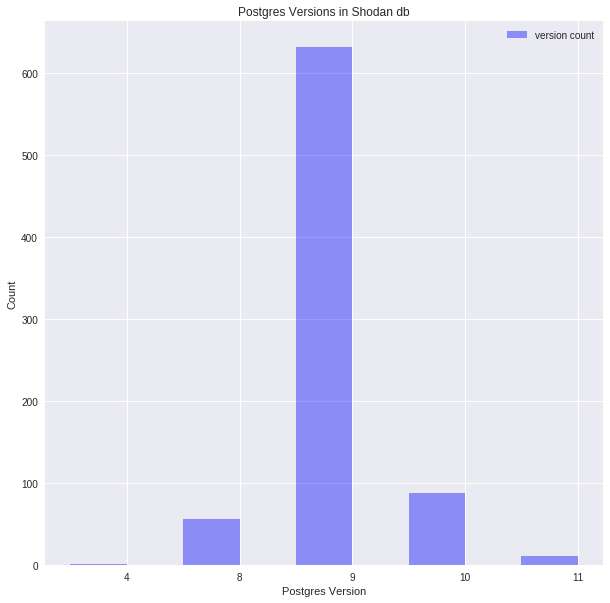

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

x = []
y = []

for v in sorted(versions['versions']):
  x.append(v)
  y.append(versions['versions'][v])


n_groups = len(x)

version_counts = y

fig, ax = plt.subplots(figsize=(10,10))

index = np.arange(n_groups)
bar_width = 0.5

opacity = 0.4

rects1 = ax.bar(index, version_counts, bar_width,
                alpha=opacity, color='b',
                label='version count')

ax.set_xlabel('Postgres Version')
ax.set_ylabel('Count')
ax.set_title('Postgres Versions in Shodan db')

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(x)
ax.legend()

plt.show()
 
# # Tweak spacing to prevent clipping of ylabel
# plt.subplots_adjust(left=0.15)
# plt.show()